<a href="https://colab.research.google.com/github/raulbenitez/AMRITA_UPC/blob/main/generate_blobs_properties.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Generate blobs database

In [1]:
from skimage import data, measure
import skimage as sk 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

L = 256 
N = 50 # number of images

I = np.zeros((L,L,N))
v = np.zeros(N)
for k in range(N):
  I_aux = data.binary_blobs(length=L, blob_size_fraction=0.1,volume_fraction=0.3)
  I[:,:,k] = I_aux
  label_image, nregions = measure.label(I[:,:,k],return_num=True)

  props_aux = measure.regionprops_table(label_image,properties=['label','area','eccentricity','extent'])

  if k == 0:
    df = pd.DataFrame(props_aux)
  else: 
    df = df.append(pd.DataFrame(props_aux), ignore_index=True)

  df_aux = pd.DataFrame(props_aux)
  a_max = max(df_aux['area'].values)

# label images with a blob with area larger than 4000 as abnormal type (class label = 1)
  if a_max > 4000:
    v[k] = 1

  print('Image number {}, number of regions {}, area of largest region {}, class {}'.format(k,nregions,a_max,v[k]))

Image number 0, number of regions 33, area of largest region 2390, class 0.0
Image number 1, number of regions 27, area of largest region 4382, class 1.0
Image number 2, number of regions 28, area of largest region 5537, class 1.0
Image number 3, number of regions 36, area of largest region 2422, class 0.0
Image number 4, number of regions 34, area of largest region 3975, class 0.0
Image number 5, number of regions 33, area of largest region 2973, class 0.0
Image number 6, number of regions 32, area of largest region 4536, class 1.0
Image number 7, number of regions 28, area of largest region 7949, class 1.0
Image number 8, number of regions 31, area of largest region 4494, class 1.0
Image number 9, number of regions 25, area of largest region 4808, class 1.0
Image number 10, number of regions 28, area of largest region 3162, class 0.0
Image number 11, number of regions 34, area of largest region 3124, class 0.0
Image number 12, number of regions 32, area of largest region 3526, class 

In [2]:
v.shape

(50,)

Visualize the features:

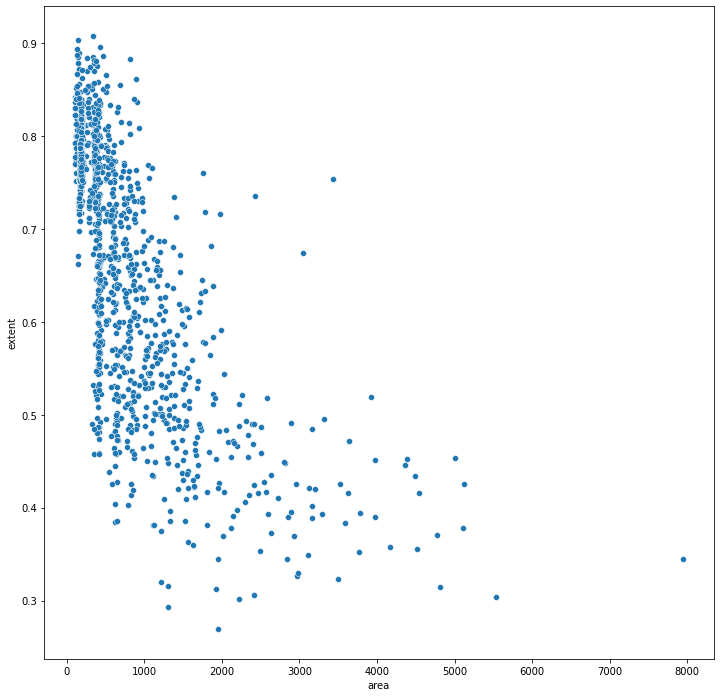

In [3]:
import seaborn as sns

fig = plt.figure(figsize=(12,12))

sns.scatterplot(x='area',y='extent',data=df)

Label image as pathological if it contains an object with an area larger than 4000

- Add background noise to images
- Set the graylevel of blobs to a value propostional to their size (Area)

In [4]:
from skimage.util import random_noise
image = random_noise(I[:,:,1], mode='gaussian', mean=0.1,var=0.01)

Train a DL model to classify images according to the class (class=0 if there are no large blobs and class = 1 if the imnage contains a large blob)


Apply a DL interpretability (gradcam++) in order to see of the large regions are more relevant to classify the anomalous images